### Siamese LSTM

**Author: Maximilian Forstenhaeusler<br>
connect: [mforstenhaeusler](https://github.com/mforstenhaeusler) | [LinkedIn](https://www.linkedin.com/in/maximilian-forstenhaeusler/)**

This notebook serves as an example on how a Siamese LSTM Neural Network can be implemented to analyse semantic similarity.

In [1]:
from siamese_lstm.dataset.quora_dataset import QuoraDataset, collate
from siamese_lstm.dataset.utils import convert_data_to_tuples, text_to_wordlist
from siamese_lstm.dataset.language import Language
from siamese_lstm.model.network import EmbeddingLSTMNet, SiameseNetwork
from siamese_lstm.model.model_trainer import ModelTrainer
from siamese_lstm.model.utils import create_pretrained_weights, plotConfusionMatrix, save_model
import os
import pandas as pd
import numpy as np
import wandb

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, SubsetRandomSampler

%load_ext autoreload

%autoreload 2

#### Set Global Varibles and Paths 

In [2]:
# Root and directory paths 
ROOT_PATH = os.getcwd()
DATA_FOLDER_PATH = ROOT_PATH + '/data'
GOOGLE_EMBEDDING_FOLDER_PATH = DATA_FOLDER_PATH + '/google embedding'
GOOGLE_EMBEDDING = GOOGLE_EMBEDDING_FOLDER_PATH + '/GoogleNews-vectors-negative300.bin'
MODEL_FOLDER_PATH = ROOT_PATH 
# important paths 
DATASET_FILE_PATH = DATA_FOLDER_PATH + '/mini_quora_dataset_30_50_50k.csv'
EMBEDDING_PATH = GOOGLE_EMBEDDING_FOLDER_PATH + GOOGLE_EMBEDDING

# general variables
EMBEDDING_REQUIRES_GRAD = False
NUM_LAYERS = 1

#### Hyperparameters 

In [3]:
# hyperperameters 
# adjust them to optimize the model performance

hparams = {
    'threshold': torch.Tensor([0.5]),  # threshold for determining similiarity
    'learning_rate': 1e-03,  # learning rate
    'epoch': 50,  # number of epochs
    'batch_size': 32,  # batch_size
    'hidden_dim': 100,  # number of hidden dimension
    'embedding_dim': 300,  # number of embedding dimension
    'dropout': 0.0,  # dropout
    'remove_stopwords': False,  # removes stopwords
    'stem_words': False,  # remove stem words 
    'simple': True,  # chooses simple or more complex model 
    'log_to_wandb': False,  # chooses to log to wandb or not
}

## Prepare the Dataset

#### Load the data

In [4]:
df = pd.read_csv(DATASET_FILE_PATH)

#### Select question pair and labels and prepare the data 

In [5]:
q_pair, labels = convert_data_to_tuples(df, hparams['remove_stopwords'], hparams['stem_words'])

Question Pairs:  49999


#### Create a Language

In [6]:
language = Language()
for data in [q_pair]:
    for question_pair in data:
        q1 = question_pair[0]
        q2 = question_pair[1]
        language.addSentence(q1)
        language.addSentence(q2)

### Create the PyTorch Dataset

In [7]:
quora_dataset = QuoraDataset(q_pair, language.word2index, labels)

In [8]:
# example output

for sample in quora_dataset:
    print('question 1:', sample['q1'])
    print('question 2:', sample['q2'])
    print('tokens  q1:', sample['q1_token'])
    print('tokens  q2:', sample['q2_token'])
    print('labels    :', sample['labels'])
    break

question 1: what are some different ways to make money fast
question 2: what are fast ways to make money
tokens  q1: [1, 2, 3, 4, 5, 6, 7, 8, 9]
tokens  q2: [1, 2, 9, 5, 6, 7, 8]
labels    : 1


### DataLoader

In [9]:
train_split = 0.8
val_split = 0.2

dataset_size = len(quora_dataset)
indices = list(range(dataset_size))

split_train = int(train_split*dataset_size)

shuffle_dataset = True
random_seed = 46

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[:split_train], indices[split_train:]

assert len(train_indices) + len(val_indices) == dataset_size

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=train_sampler, collate_fn=collate)
val_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=val_sampler, collate_fn=collate)

print('Training Set Size {}, Validation Set Size {},'.format(len(train_indices), len(val_indices)))


Training Set Size 39999, Validation Set Size 10000,


## Model 

In [10]:
# create pretrained weights 
# skip this step because time consuming and might make cpu brake
# instead import the pretrained_weights.pt 

# pretrained_weights = create_pretrained_weights(GOOGLE_EMBEDDING_PATH, hparams[''embedding_dim''], language)
# pretrained_weights

In [11]:
pretrained_weights = torch.load('pretrained_weights.pt')
pretrained_weights

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1396, -0.0062,  0.2148,  ...,  0.0571,  0.0996, -0.2344],
        [-0.0967, -0.0264,  0.0903,  ..., -0.0197,  0.2139,  0.1367],
        ...,
        [-0.2100, -0.3711, -0.1211,  ..., -0.0066,  0.0742, -0.0233],
        [-0.1348, -0.0233, -0.0640,  ...,  0.2051,  0.1226, -0.1250],
        [-0.0381, -0.1445,  0.1426,  ...,  0.0216,  0.0688,  0.0171]])

### Initialize PyTorch Model

In [12]:
# embedding net
embedding_net = EmbeddingLSTMNet(
    hparams['embedding_dim'],
    hparams['hidden_dim'],
    NUM_LAYERS,
    EMBEDDING_REQUIRES_GRAD,
    pretrained_weights,
    hparams['dropout'],
    hparams['simple'], # if simple=True --> simple model, if simple=False --> more complex model (2 linear layers plus relu)
)

# siamese model
model = SiameseNetwork(embedding_net)

In [13]:
# test model class with one batch from the dataloader 
for i, batch in enumerate(train_dataloader):
    q1, q2 = batch['q1_token'], batch['q2_token']
    q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
    y = torch.FloatTensor(batch['labels'])

model(q1, q2, q1_len, q2_len)

tensor([4.2786e-03, 2.2982e-02, 8.7775e-03, 1.0136e-01, 6.3616e-03, 5.6393e-03,
        1.5471e-02, 6.5313e-07, 4.6945e-04, 5.9758e-01, 1.2988e-08, 8.1944e-04,
        3.9577e-07, 8.4864e-05, 8.5776e-01, 5.0677e-01, 6.4650e-01, 5.7984e-03,
        1.0207e-01, 7.1474e-02, 3.5781e-02, 1.4031e-04, 3.7408e-01, 9.9076e-03,
        1.6562e-01, 5.5860e-01, 1.1024e-02, 1.0810e-01, 2.4746e-01, 6.8180e-02,
        5.2148e-01], grad_fn=<CopySlices>)

### Training

#### Initialize the ModelTrainer

In [14]:
trainer = ModelTrainer(
    model, 
    hparams, 
    train_dataloader, 
    val_dataloader,
    train_indices, 
    val_indices,
    log_to_wandb=hparams['log_to_wandb'],
)

#### Fit the model

In [15]:
trainer.fit()

Epoch [1/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.11batch/s, train_acc=84.375 %, train_loss=0.211]


Epoch [1/50] Validation: val_loss: 0.18572854931457355 val_acc: 72.87 %


Epoch [2/50]  Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.56batch/s, train_acc=78.125 %, train_loss=0.176]


Epoch [2/50] Validation: val_loss: 0.17632684804284915 val_acc: 74.53 %


Epoch [3/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.46batch/s, train_acc=75.0 %, train_loss=0.164]  


Epoch [3/50] Validation: val_loss: 0.17207175926469004 val_acc: 75.67 %


Epoch [4/50]  Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.07batch/s, train_acc=87.5 %, train_loss=0.157]  


Epoch [4/50] Validation: val_loss: 0.16990874705318446 val_acc: 75.82 %


Epoch [5/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.68batch/s, train_acc=68.75 %, train_loss=0.151]


Epoch [5/50] Validation: val_loss: 0.1670975553008695 val_acc: 75.99000000000001 %


Epoch [6/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.82batch/s, train_acc=62.5 %, train_loss=0.147]  


Epoch [6/50] Validation: val_loss: 0.16675287170912892 val_acc: 76.55 %


Epoch [7/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 39.00batch/s, train_acc=90.625 %, train_loss=0.143]


Epoch [7/50] Validation: val_loss: 0.16431928709292185 val_acc: 76.61 %


Epoch [8/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.50batch/s, train_acc=75.0 %, train_loss=0.14]  


Epoch [8/50] Validation: val_loss: 0.1637403867638911 val_acc: 77.08 %


Epoch [9/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.67batch/s, train_acc=96.875 %, train_loss=0.137]


Epoch [9/50] Validation: val_loss: 0.16283673383652592 val_acc: 76.95 %


Epoch [10/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.26batch/s, train_acc=90.625 %, train_loss=0.135]


Epoch [10/50] Validation: val_loss: 0.16174951324257225 val_acc: 77.03999999999999 %


Epoch [11/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.85batch/s, train_acc=87.5 %, train_loss=0.133]  


Epoch [11/50] Validation: val_loss: 0.16121463998914146 val_acc: 77.33 %


Epoch [12/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.60batch/s, train_acc=93.75 %, train_loss=0.13] 


Epoch [12/50] Validation: val_loss: 0.16132164720338754 val_acc: 77.10000000000001 %


Epoch [13/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.73batch/s, train_acc=93.75 %, train_loss=0.129]


Epoch [13/50] Validation: val_loss: 0.16047268456068284 val_acc: 77.25999999999999 %


Epoch [14/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.89batch/s, train_acc=84.375 %, train_loss=0.127]


Epoch [14/50] Validation: val_loss: 0.16022053251441676 val_acc: 77.22 %


Epoch [15/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.17batch/s, train_acc=90.625 %, train_loss=0.126]


Epoch [15/50] Validation: val_loss: 0.15991931708571247 val_acc: 77.42999999999999 %


Epoch [16/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.38batch/s, train_acc=90.625 %, train_loss=0.125]


Epoch [16/50] Validation: val_loss: 0.15955296120704554 val_acc: 77.53999999999999 %


Epoch [17/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.37batch/s, train_acc=90.625 %, train_loss=0.124]


Epoch [17/50] Validation: val_loss: 0.15935345936697512 val_acc: 77.62 %


Epoch [18/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.31batch/s, train_acc=84.375 %, train_loss=0.123]


Epoch [18/50] Validation: val_loss: 0.15947055959473022 val_acc: 77.66999999999999 %


Epoch [19/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.20batch/s, train_acc=78.125 %, train_loss=0.122]


Epoch [19/50] Validation: val_loss: 0.15933148246318007 val_acc: 77.56 %


Epoch [20/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 39.04batch/s, train_acc=78.125 %, train_loss=0.121]


Epoch [20/50] Validation: val_loss: 0.15907437875628852 val_acc: 77.7 %


Epoch [21/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 39.01batch/s, train_acc=78.125 %, train_loss=0.12]


Epoch [21/50] Validation: val_loss: 0.15940751808996018 val_acc: 77.46 %


Epoch [22/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.47batch/s, train_acc=96.875 %, train_loss=0.119]


Epoch [22/50] Validation: val_loss: 0.1591235170491968 val_acc: 77.64 %


Epoch [23/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.57batch/s, train_acc=84.375 %, train_loss=0.119]


Epoch [23/50] Validation: val_loss: 0.15903449667909275 val_acc: 77.55 %


Epoch [24/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.15batch/s, train_acc=90.625 %, train_loss=0.118]


Epoch [24/50] Validation: val_loss: 0.15911234900974236 val_acc: 77.53999999999999 %


Epoch [25/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.38batch/s, train_acc=71.875 %, train_loss=0.118]


Epoch [25/50] Validation: val_loss: 0.15863673238994214 val_acc: 77.59 %


Epoch [26/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.04batch/s, train_acc=93.75 %, train_loss=0.117] 


Epoch [26/50] Validation: val_loss: 0.15873588538303163 val_acc: 77.55 %


Epoch [27/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.74batch/s, train_acc=90.625 %, train_loss=0.117]


Epoch [27/50] Validation: val_loss: 0.15909627558419498 val_acc: 77.4 %


Epoch [28/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.79batch/s, train_acc=84.375 %, train_loss=0.117]


Epoch [28/50] Validation: val_loss: 0.15868007570219497 val_acc: 77.46 %


Epoch [29/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.12batch/s, train_acc=96.875 %, train_loss=0.116]


Epoch [29/50] Validation: val_loss: 0.1588394823737038 val_acc: 77.49000000000001 %


Epoch [30/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.28batch/s, train_acc=90.625 %, train_loss=0.116]


Epoch [30/50] Validation: val_loss: 0.1593228221272889 val_acc: 77.34 %


Epoch [31/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.57batch/s, train_acc=87.5 %, train_loss=0.116]  


Epoch [31/50] Validation: val_loss: 0.1590571764130562 val_acc: 77.45 %


Epoch [32/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.96batch/s, train_acc=84.375 %, train_loss=0.115]


Epoch [32/50] Validation: val_loss: 0.15912379452976555 val_acc: 77.44 %


Epoch [33/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.42batch/s, train_acc=87.5 %, train_loss=0.116]  


Epoch [33/50] Validation: val_loss: 0.15908645233883265 val_acc: 77.41 %


Epoch [34/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.79batch/s, train_acc=84.375 %, train_loss=0.115]


Epoch [34/50] Validation: val_loss: 0.159128834573796 val_acc: 77.46 %


Epoch [35/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.20batch/s, train_acc=75.0 %, train_loss=0.115]  


Epoch [35/50] Validation: val_loss: 0.15890209945722128 val_acc: 77.47 %


Epoch [36/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.22batch/s, train_acc=96.875 %, train_loss=0.115]


Epoch [36/50] Validation: val_loss: 0.15898507590682362 val_acc: 77.48 %


Epoch [37/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.31batch/s, train_acc=84.375 %, train_loss=0.115]


Epoch [37/50] Validation: val_loss: 0.1589104368711432 val_acc: 77.44 %


Epoch [38/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.15batch/s, train_acc=81.25 %, train_loss=0.114] 


Epoch [38/50] Validation: val_loss: 0.15917657199092566 val_acc: 77.49000000000001 %


Epoch [39/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 39.04batch/s, train_acc=84.375 %, train_loss=0.114]


Epoch [39/50] Validation: val_loss: 0.15890738201407958 val_acc: 77.49000000000001 %


Epoch [40/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.78batch/s, train_acc=90.625 %, train_loss=0.114]


Epoch [40/50] Validation: val_loss: 0.1589723387703347 val_acc: 77.47 %


Epoch [41/50]  Training: 100%|██████████| 1250/1250 [00:33<00:00, 37.09batch/s, train_acc=84.375 %, train_loss=0.114]


Epoch [41/50] Validation: val_loss: 0.15921680048441353 val_acc: 77.47 %


Epoch [42/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.68batch/s, train_acc=78.125 %, train_loss=0.114]


Epoch [42/50] Validation: val_loss: 0.15913050724104189 val_acc: 77.39 %


Epoch [43/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.97batch/s, train_acc=90.625 %, train_loss=0.114]


Epoch [43/50] Validation: val_loss: 0.15884759141423832 val_acc: 77.42 %


Epoch [44/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.95batch/s, train_acc=93.75 %, train_loss=0.114] 


Epoch [44/50] Validation: val_loss: 0.15894757689664157 val_acc: 77.48 %


Epoch [45/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 37.94batch/s, train_acc=93.75 %, train_loss=0.114] 


Epoch [45/50] Validation: val_loss: 0.15890282035445252 val_acc: 77.53 %


Epoch [46/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.83batch/s, train_acc=75.0 %, train_loss=0.114]  


Epoch [46/50] Validation: val_loss: 0.15902736963936315 val_acc: 77.45 %


Epoch [47/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.60batch/s, train_acc=87.5 %, train_loss=0.113] 


Epoch [47/50] Validation: val_loss: 0.15893699283512255 val_acc: 77.53 %


Epoch [48/50]  Training: 100%|██████████| 1250/1250 [00:32<00:00, 38.25batch/s, train_acc=68.75 %, train_loss=0.113]


Epoch [48/50] Validation: val_loss: 0.15886004949910953 val_acc: 77.47 %


Epoch [49/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.10batch/s, train_acc=96.875 %, train_loss=0.113]


Epoch [49/50] Validation: val_loss: 0.15908666676320968 val_acc: 77.51 %


Epoch [50/50]  Training: 100%|██████████| 1250/1250 [00:31<00:00, 39.42batch/s, train_acc=81.25 %, train_loss=0.114] 


Epoch [50/50] Validation: val_loss: 0.1588734276235675 val_acc: 77.49000000000001 %


### Evaluation 

- - - Model Performance - - -

Model Accuracy:  77.49000000000001
Correct predictions: 7749, Incorret predictions: 2251



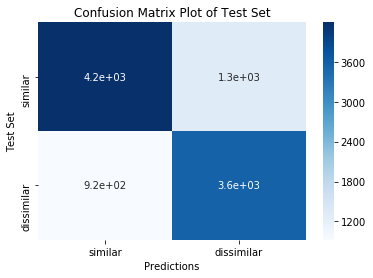

TP: 4192
FP: 924
FN: 1327
TN: 3557

Percision Score: 0.7282964782964783
Recall Score: 0.7937960276723945
F1 Score: 0.7596369460758142


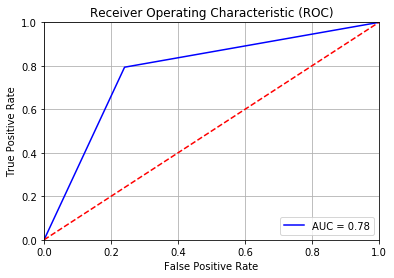

In [16]:
trainer.test()

#### Store Model

In [17]:
# If you like to store the model, uncomment the following lines and enter filename and path 

#filename = "model.pt"
#path = ROOT_PATH
#save_model(model, path + "/" + filename)

## Make predicitions

Use you the previously trained model to make prediction on some samples. At the end one can input a custom question pair and see how the model is performing on it.

#### Checkout random sample from training data

In [18]:
ind = np.random.choice(len(train_dataloader))
test_sample_train = dict()
for idx, batch in enumerate(train_dataloader):
    if idx == ind:
        test_sample_train['q1_text'] = [batch['q1_text'][0]]
        test_sample_train['q2_text'] = [batch['q2_text'][0]]
        test_sample_train['q1_token'] = [batch['q1_token'][0]]
        test_sample_train['q2_token'] = [batch['q2_token'][0]]
        test_sample_train['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_train['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_train['labels'] = [batch['labels'][0]]

trainer.predict(test_sample_train)

question 1: ['which is the best movie of 2016']
question 2: ['which movies are the best in 2016']
tokens  q1: [[126, 22, 23, 24, 520, 37, 308]]
tokens  q2: [[126, 523, 2, 23, 24, 30, 308]]


Model predicts 1.0 --> Actual value 1.0
Model prediction is correct :)

The questions ['which is the best movie of 2016'] and ['which movies are the best in 2016'] are similar!


#### Checkout random sample from validation data

In [19]:
ind = np.random.choice(len(val_dataloader))

test_sample_val = dict()
for idx, batch in enumerate(val_dataloader):
    if idx == ind:
        test_sample_val['q1_text'] = [batch['q1_text'][0]]
        test_sample_val['q2_text'] = [batch['q2_text'][0]]
        test_sample_val['q1_token'] = [batch['q1_token'][0]]
        test_sample_val['q2_token'] = [batch['q2_token'][0]]
        test_sample_val['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_val['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_val['labels'] = [batch['labels'][0]]

trainer.predict(test_sample_val)

question 1: ['how can i get android developer job in htc']
question 2: ['how do i get android developer job']
tokens  q1: [[10, 11, 12, 139, 111, 1867, 539, 30, 9434]]
tokens  q2: [[10, 18, 12, 139, 111, 1867, 539]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['how can i get android developer job in htc'] and ['how do i get android developer job'] are dissimilar!


### Predict from custom input questions

In [20]:
default = True  # set to False to create your own inputs
similar = False  # select False to dispaly dissimlar example

if default:
    if similar:
        q1 = ['Is it cold today?']
        q2 = ['Will it be cold today?']
        label = [1.0]
    else:
        q1 = ['Will I pass the final?']
        q2 = ['What will I have for dinner tonight?']
        label = [0.0]
else:
    q1 = input(r'Enter your 1^st question: ')
    q2 = input(r'Enter your 2^nd question: ')
    label = input('label: ') # 0 for dissimilar, 1 for similar 
    q1 = [q1]
    q2 = [q2]
    label = [label]

In [21]:
# prepair custom input
# create df
df_own = pd.DataFrame(list(zip(q1, q2, label)), columns=['question1', 'question2', 'is_duplicate'])
# prepare data 
q_pair_own, label = convert_data_to_tuples(df_own, hparams['remove_stopwords'], hparams['stem_words'])
print(q_pair_own)

# create dataset 
own_dataset = QuoraDataset(q_pair_own, language.word2index, label)

# create dataloader
predict_dataloader = torch.utils.data.DataLoader(own_dataset, batch_size=1, collate_fn=collate)

for sample in predict_dataloader:
    test_sample = sample

# predict 
trainer.predict(test_sample)

Question Pairs:  1
[('will i pass the final', 'what will i have for dinner tonight')]
question 1: ['will i pass the final']
question 2: ['what will i have for dinner tonight']
tokens  q1: [[41, 12, 1487, 23, 1303]]
tokens  q2: [[1, 41, 12, 165, 63, 4425, 11626]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['will i pass the final'] and ['what will i have for dinner tonight'] are dissimilar!
